In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly evaluation of dogecoin price.

In [2]:
doge = pd.read_csv('data/doge_data.csv')
doge = doge.rename(columns={'Datetime':'date'})
doge['date'] = pd.to_datetime(doge['date'], errors='coerce')
doge = doge.set_index('date')
doge = doge.drop(['Open', 'High','Low', 'Adj Close','Volume'], axis=1)

doge.tail()

,Close
date,
2021-04-01 18:00:00+00:00,0.058724
2021-04-01 19:00:00+00:00,0.058545
2021-04-01 20:00:00+00:00,0.059997
2021-04-01 21:00:00+00:00,0.059294
2021-04-01 22:00:00+00:00,0.060175


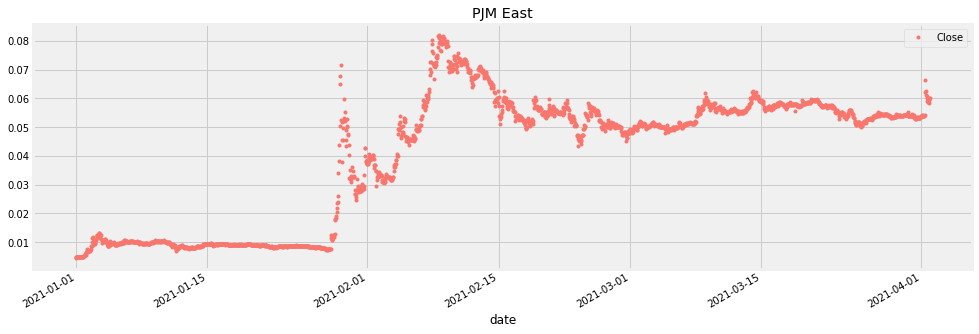

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = doge.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [4]:
split_date = '2021-03-21 22:00:00+00:00'
doge_train = doge.loc[doge.index <= split_date].copy()
doge_test = doge.loc[doge.index > split_date].copy()

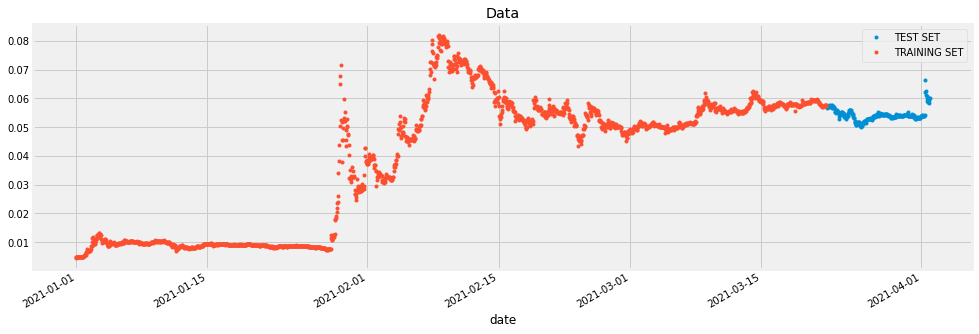

In [5]:
_ = doge_test \
    .rename(columns={'Close': 'TEST SET'}) \
    .join(doge_train.rename(columns={'Close': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Data', style='.')

# Create Time Series Features

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(doge_train, label='Close')
X_test, y_test = create_features(doge_test, label='Close')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


# Create XGBoost Model

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[22:19:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

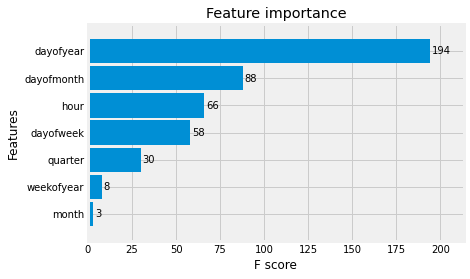

In [9]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [10]:
doge_test['Close_Prediction'] = reg.predict(X_test)
doge_all = pd.concat([doge_test, doge_train], sort=False)

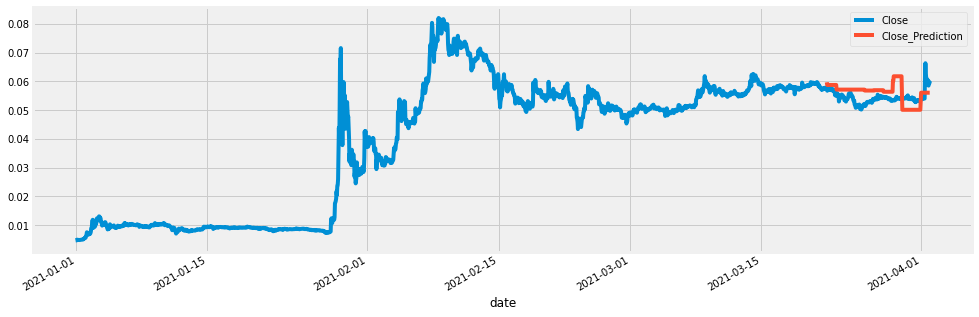

In [11]:
_ = doge_all[['Close','Close_Prediction']].plot(figsize=(15, 5))